<a href="https://colab.research.google.com/github/jubacochran/NLP/blob/main/Experiment_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**(This is the experimentation Notebook. The Final model will be uploaded seperately**)


**Objective:** My goal was to build a LLM with the best performance in the interest of time. I experimented with many layers, methodologies and optimization techniques (Adam, SGD, RMSProp, Adagrad) to understand their impact on the model’s performance.

[Dataset](https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format/data):
The chosen dataset was the IMDB Sentiment Analysis dataset from Kaggle, which contains labeled text data for sentiment classification. The dataset is balanced, with an equal distribution of positive and negative reviews . Preprocessing involved tokenization, padding, and splitting into training and testing sets.

**Model Design:**
Initially, a basic LSTM model with an embedding layer was used, which performed suboptimally due to long training times and poor accuracy. The model architecture was as follows:

**Embedding Layer:** Converts words into dense vectors.
LSTM Layer: 512 units for learning sequential dependencies.
Dense Layer: A fully connected layer with 65,881 output units.
The initial training run revealed very high loss values and poor accuracy (starting at 0.0362), which prompted a rethinking of the approach. The model took more than 10 hours to train for just the first epoch.

**Refinement (ULMFiT):**
After reviewing research from Jay Alammar and Maarten Grootendorst’s "Hands-On Large Language Models," the Universal Language Model Fine-tuning (ULMFiT) method was implemented. ULMFiT is a transfer learning approach, using pre-trained models to improve efficiency and performance in task-specific applications.

**Base Model: **Used the DistilBERT-base-uncased transformer model for its lightweight nature.

**Task-specific Model:** The model was fine-tuned using twitter-roberta-base-sentiment-latest, a pre-trained model tailored for sentiment analysis tasks.

**Classification Head:** Added a classification layer on top for binary sentiment prediction.
Optimization:
The optimization technique was experimented with multiple algorithms through hyperparameter sweeps with Weights & Biases (W&B):

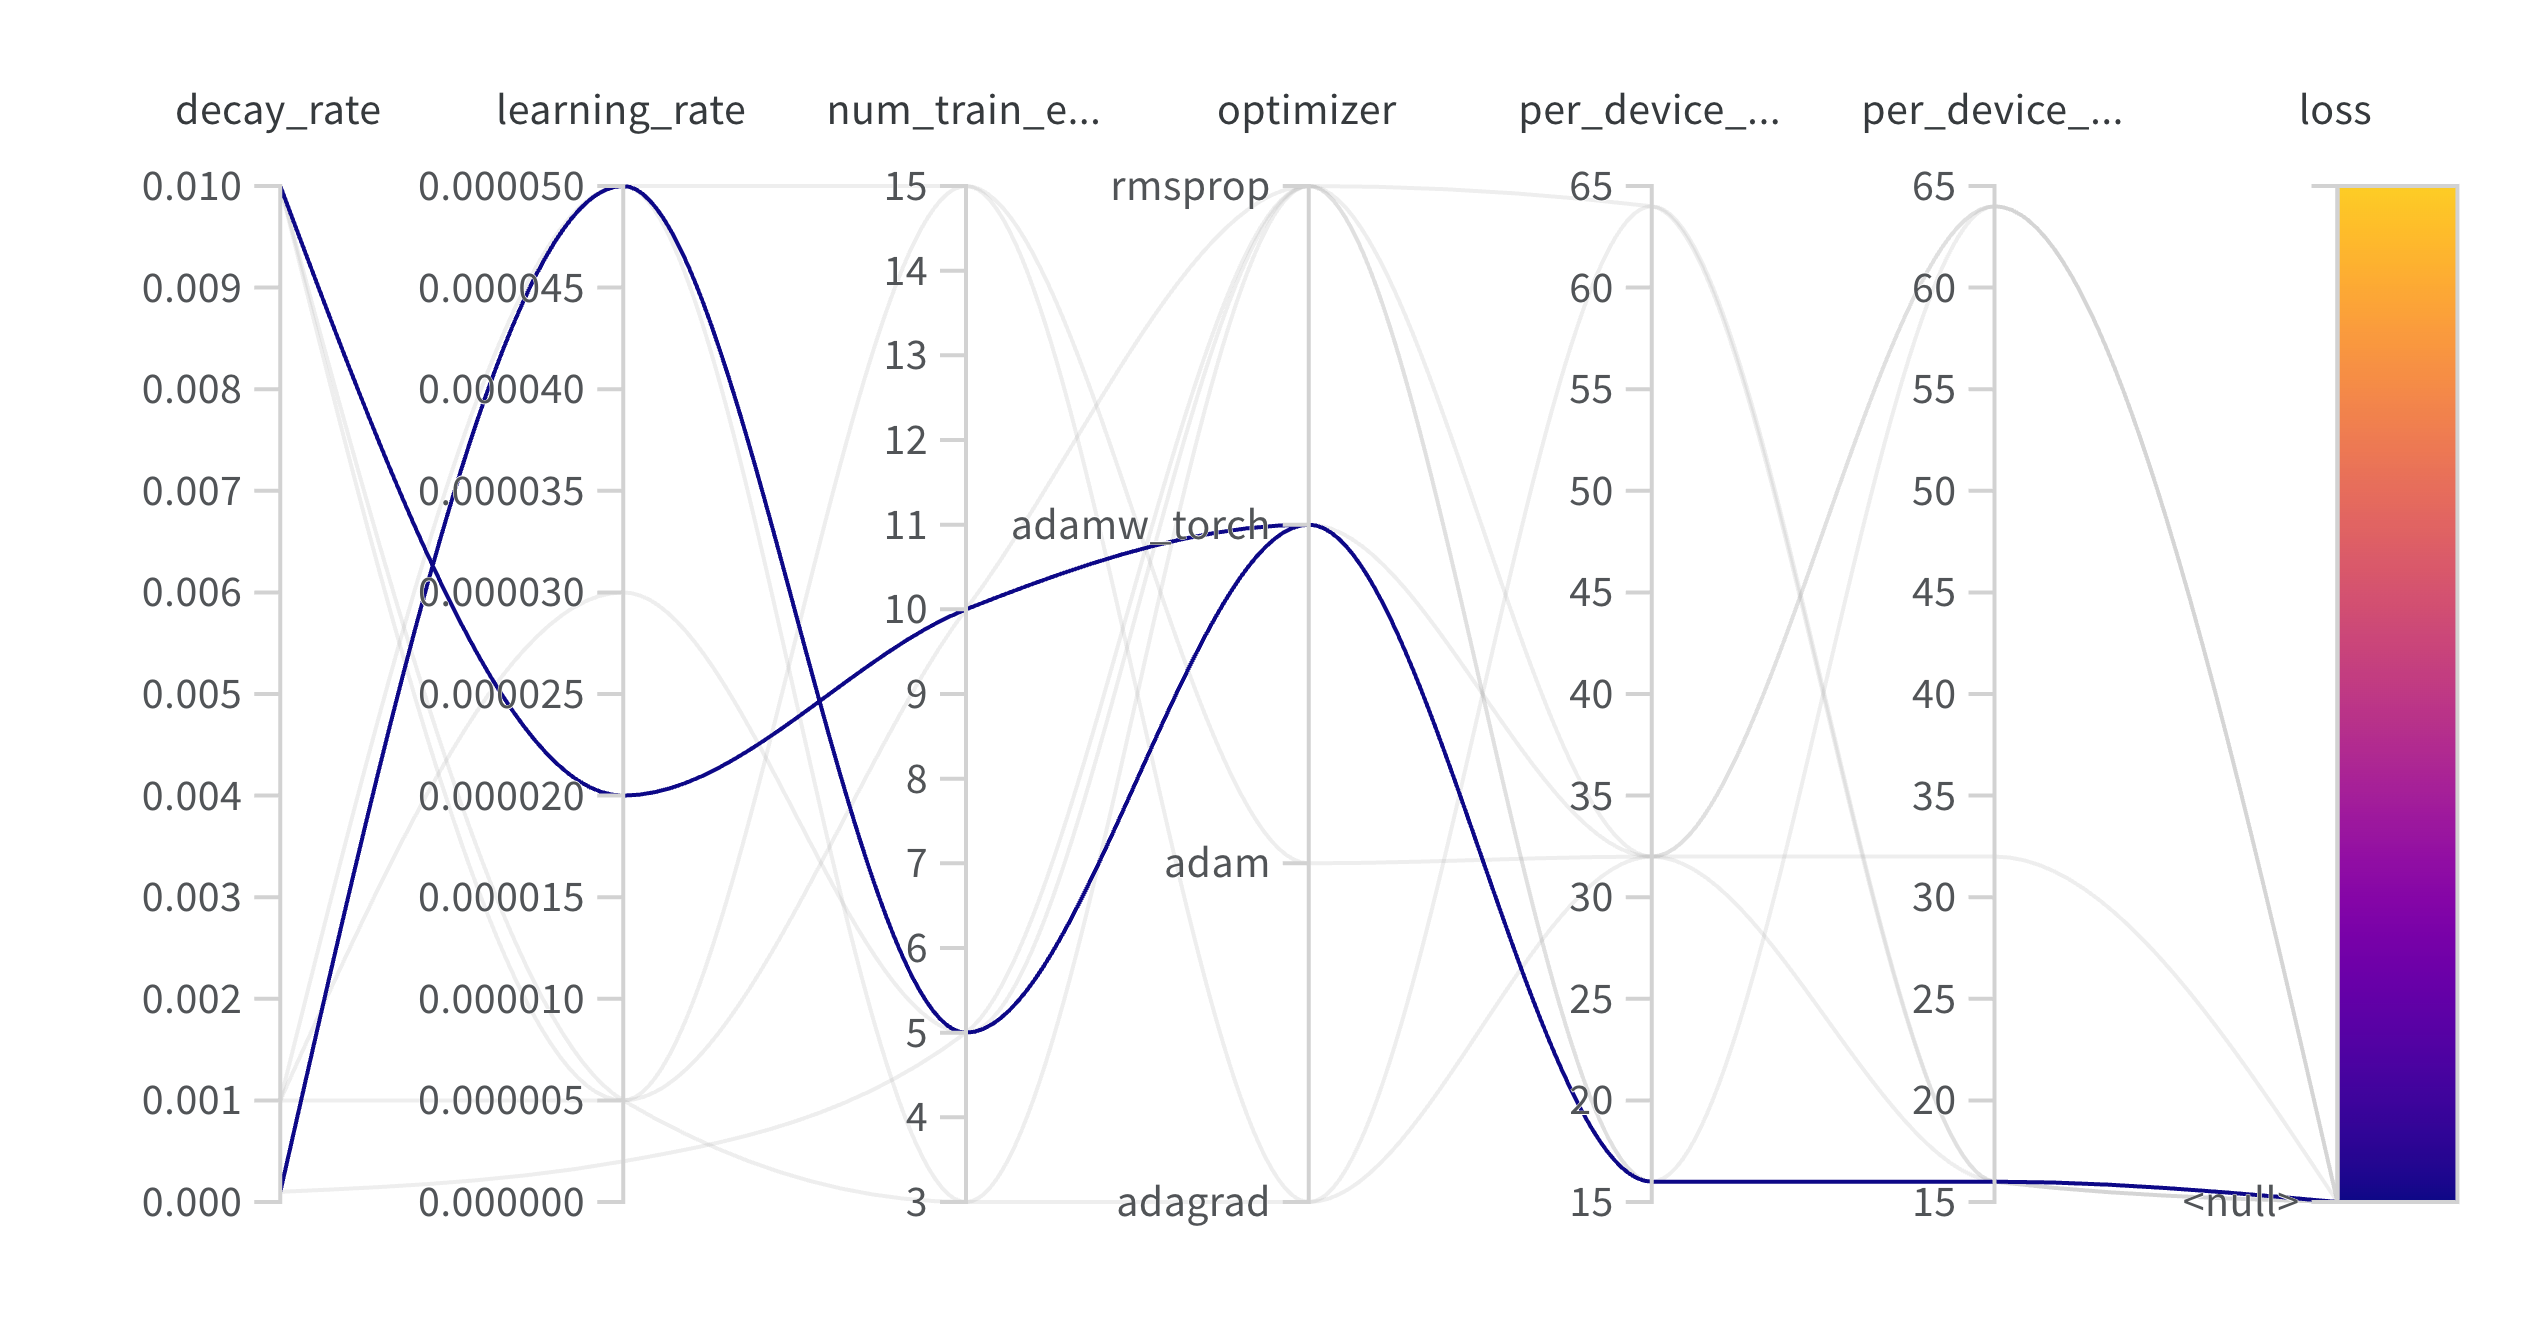

**Hyperparameter Sweep:** Parameters such as decay rate, learning rate, batch size, number of epochs, and optimizer were tested.
Optimizers Tested: AdamW, Adam, SGD, RMSProp, Adagrad.
Results from Hyperparameter Tuning (via W&B):
After 5 epochs, the model showed impressive improvements:

Validation Accuracy: ~92%
Test Accuracy: ~91.4%
Precision: ~92.1%
Recall: ~91.4%
F1-Score: ~91.4%
Loss: ~0.93
The W&B charts show that AdamW with learning rate 5e-5 and a decay rate of 0.0001 performed the best, as it minimized the loss function and resulted in stable performance.
Key Insights:

Activation Functions: The primary experiment involved using different activation functions (Sigmoid, Tanh, and ReLU) within the model’s architecture. ReLU generally provided the best performance across layers, enabling faster convergence.
Optimization Technique: The AdamW optimizer consistently outperformed others like SGD and Adagrad in terms of accuracy, precision, recall, and F1 score. RMSProp also yielded promising results.
Transfer Learning: The use of pre-trained models (DistilBERT and Roberta) through the ULMFiT approach allowed for faster convergence and higher performance compared to training from scratch.
Training Time: By shifting to Google Colab's GPU services and optimizing the training pipeline, training time was drastically reduced (from over 10 hours per epoch to approximately 1 hour per epoch).
Final Model:
The final model, after 15 epochs, achieved the following on the test set:

Accuracy: 91.56%
Precision: 91.48%
Recall: 91.38%
F1-Score: 91.39%
Loss: 1.32
This model demonstrates high efficacy in sentiment classification tasks, validating the impact of transfer learning and optimized hyperparameters.

You can reference the [W&B project]()https://chatgpt.com/c/675d5bc8-2148-8012-a453-eadeece490ac#:~:text=can%20reference%20the-,W%26B%20project,-for%20detailed%20metrics for detailed metrics, and experiment details can be found in the logs.

In [ ]:
pip install --upgrade datasets gcsfs


  Using cached gcsfs-2024.10.0-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of gcsfs to determine which version is compatible with other requirements. This could take a while.


In [ ]:
pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: jubacochran (jubacochran-booking-com). Use `wandb login --relogin` to force relogin


In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer,pipeline, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
torch.cuda.is_available()
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import wandb
import random
import math
import numpy as np



In [ ]:
#Load model and tokenizer
modelBase_name = 'distilbert/distilbert-base-uncased'
modelTaskSpecific_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

tokenizer   = AutoTokenizer.from_pretrained(modelBase_name)
model = AutoModelForSequenceClassification.from_pretrained(
    modelBase_name,
    num_labels=2
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

train_df = pd.read_csv("/content/sentiment_analysis/Train.csv")
val_df = pd.read_csv("/content/sentiment_analysis/Valid.csv")
test_df = pd.read_csv("/content/sentiment_analysis/Test.csv")

dataset = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}


print("Number of training samples:", len(dataset["train"]))
print("Number of validation samples:", len(dataset["val"]))
print("Number of test samples:", len(dataset["test"]))


Number of training samples: 40000
Number of validation samples: 5000
Number of test samples: 5000


In [ ]:
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)


In [ ]:
print(dataset['train'])
print(dataset['train'].info())

                                                    text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-nul

label
0    20019
1    19981
Name: count, dtype: int64
0


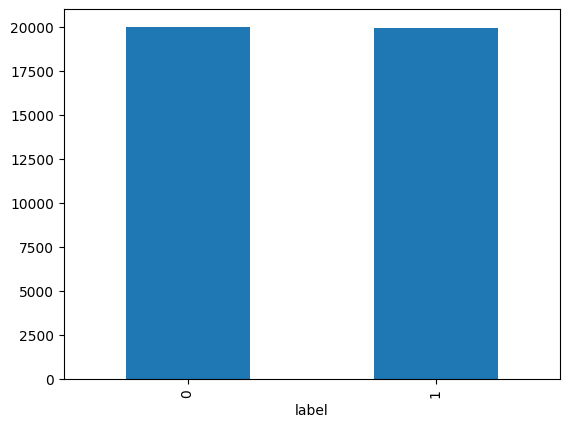

In [ ]:
dataset['train']['label'].value_counts().plot(kind='bar')
print(dataset['train']['label'].value_counts())
print(dataset['train']['label'].isna().sum())



label
1    2514
0    2486
Name: count, dtype: int64
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


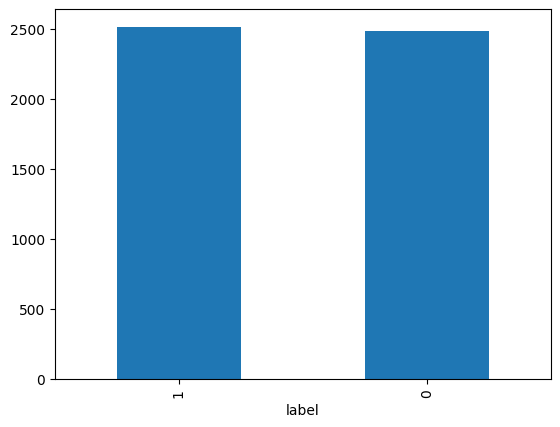

In [ ]:
dataset['val']['label'].value_counts().plot(kind='bar')
print(dataset['val']['label'].value_counts())
print(dataset['val']['label'].isna().sum())
print(dataset['val']['label'].isnull().sum())
print(dataset['val'].info())

label
1    2505
0    2495
Name: count, dtype: int64
0
0


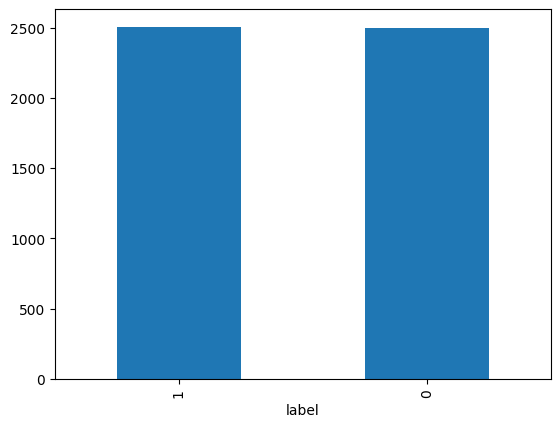

In [ ]:
dataset['test']['label'].value_counts().plot(kind='bar')
print(dataset['test']['label'].value_counts())
print(dataset['test']['label'].isna().sum())
print(dataset['test']['label'].isnull().sum())

The Training classes are balanced

In [ ]:
#Converting pandas to hugging face dataset

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [ ]:
print(raw_datasets)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [ ]:
print(len(raw_datasets["train"][0]['text']))

874


In [ ]:
#Taking a look at a single document
length=tokenizer(raw_datasets["train"][0]['text'])
print(len(length['input_ids']))


189


In [ ]:

def tokenize_function(df):
    return tokenizer(df["text"], truncation=False, padding=False)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

#get all lengths for the train set
train_lengths = [len(ids) for ids in tokenized_datasets["train"]["input_ids"]]

print("Max length in train:", max(train_lengths))
print("Min length in train:", min(train_lengths))

#same for validation and test sets:
val_lengths = [len(ids) for ids in tokenized_datasets["validation"]["input_ids"]]
test_lengths = [len(ids) for ids in tokenized_datasets["test"]["input_ids"]]

print("Max length in val:", max(val_lengths))
print("Min length in val:", min(val_lengths))
print("Max length in test:", max(test_lengths))
print("Min length in test:", min(test_lengths))


pcts = [50, 75, 90, 95, 99]
for p in pcts:
    val = np.percentile(train_lengths, p)
    print(f"{p}th percentile: {val}")


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1384 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Max length in train: 3157
Min length in train: 10
Max length in val: 2315
Min length in val: 13
Max length in test: 3035
Min length in test: 14
50th percentile: 232.0
75th percentile: 378.0
90th percentile: 610.0
95th percentile: 794.0
99th percentile: 1198.0


In [ ]:
#Data tokenization

def preprocess(df, truncation=True):
    return tokenizer(df['text'], truncation=True, padding=True,max_length=512)


In [ ]:
#Tokenizing all three datasets
tokenized_datasets = raw_datasets.map(preprocess, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
if 'label' in tokenized_datasets["train"].column_names:
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [ ]:
#Create tensors

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")


In [ ]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})


In [ ]:
labels = tokenized_datasets["train"]['labels']
print(labels.unique(return_counts=True))



(tensor([0, 1]), tensor([20019, 19981]))


In [ ]:
labels = tokenized_datasets["validation"]['labels']
print(labels.unique(return_counts=True))

(tensor([0, 1]), tensor([2486, 2514]))


In [ ]:
labels = tokenized_datasets["test"]['labels']
print(labels.unique(return_counts=True))

(tensor([0, 1]), tensor([2495, 2505]))


In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'per_device_train_batch_size': {
            'values': [16, 32, 64]
        },
        'per_device_eval_batch_size': {
            'values': [16, 32, 64]
        },
        'decay_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'num_train_epochs': {
            'values': [3, 5, 10, 15]
        },
        'learning_rate': {
            'values': [1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 3e-5, 5e-5, 1e-4]
        },
        'optimizer': {
            'values': ['adamw_torch', 'adam', 'sgd', 'rmsprop', 'adagrad']
        }
    }
}


In [ ]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import wandb
from transformers import TrainingArguments, Trainer

def train_with_hyperparams(config=None):
    # Initialize wandb run with config
    with wandb.init(config=config, project="IMDB-sentiment-project"):
        config = wandb.config

        # Set up training arguments, using values from the sweep config
        training_args = TrainingArguments(
            output_dir="output",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.per_device_train_batch_size,
            per_device_eval_batch_size=config.per_device_eval_batch_size,
            num_train_epochs=config.num_train_epochs,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            logging_dir="./logs",
            logging_strategy="steps",
            logging_steps=100,
            gradient_checkpointing=False,
            fp16=False,
            bf16=False,
            optim=config.optimizer,
            report_to="wandb",
            run_name=f"deberta-run-lr{config.learning_rate}-bs{config.per_device_train_batch_size}-ep{config.num_train_epochs}"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics
        )

        trainer.train()
        val_results = trainer.evaluate()
        wandb.log(val_results)

        test_results = trainer.predict(test_dataset)
        wandb.log({"test_accuracy": test_results.metrics["test_accuracy"],
                   "test_f1": test_results.metrics["test_f1"]})

        # Print results if you want
        print("Validation Results:", val_results)
        print("Test Results:", test_results.metrics)


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="IMDB-sentiment-project")

Create sweep with ID: qita39jj
Sweep URL: https://wandb.ai/jubacochran-booking-com/IMDB-sentiment-project/sweeps/qita39jj


In [ ]:
wandb.agent(sweep_id, function=train_with_hyperparams, count=10)

wandb: Agent Starting Run: 879oxtrv with config:
wandb: 	decay_rate: 0.0001
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	optimizer: adamw_torch
wandb: 	per_device_eval_batch_size: 16
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.014300,0.832967,0.919400,0.919400,0.919400,0.919400
2,0.015400,0.815482,0.919000,0.919140,0.919000,0.918989
3,0.000000,0.764985,0.920600,0.921270,0.920600,0.920559
4,0.002300,0.889028,0.916800,0.918123,0.916800,0.916720
5,0.000000,0.934853,0.921000,0.921428,0.921000,0.920972


Validation Results: {'eval_loss': 0.9348529577255249, 'eval_accuracy': 0.921, 'eval_precision': 0.9214282335692741, 'eval_recall': 0.921, 'eval_f1': 0.9209720870946708, 'eval_runtime': 17.0885, 'eval_samples_per_second': 292.595, 'eval_steps_per_second': 18.316, 'epoch': 5.0}
Test Results: {'test_loss': 1.0063059329986572, 'test_accuracy': 0.9144, 'test_precision': 0.9151113744383523, 'test_recall': 0.9144, 'test_f1': 0.9143593839421484, 'test_runtime': 17.457, 'test_samples_per_second': 286.418, 'test_steps_per_second': 17.93}


epoch,▁
eval/accuracy,▅▅▇▁██
eval/f1,▅▅▇▁██
eval/loss,▄▃▁▆██
eval/precision,▄▃█▁██
eval/recall,▅▅▇▁██
eval/runtime,▁▁▂▇██
eval/samples_per_second,██▇▂▁▁
eval/steps_per_second,██▇▂▁▁
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: 14x6m5dq with config:
wandb: 	decay_rate: 0.0001
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	optimizer: adamw_torch
wandb: 	per_device_eval_batch_size: 32
wandb: 	per_device_train_batch_size: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002300,0.741213,0.921400,0.922444,0.921400,0.921363
2,0.004100,0.778633,0.921400,0.921567,0.921400,0.921387
3,0.001400,0.838882,0.923200,0.923266,0.923200,0.923200
4,0.000600,0.911786,0.923800,0.924135,0.923800,0.923791
5,0.000000,0.921076,0.922600,0.922825,0.922600,0.922584


Validation Results: {'eval_loss': 0.9117861390113831, 'eval_accuracy': 0.9238, 'eval_precision': 0.9241347733903209, 'eval_recall': 0.9238, 'eval_f1': 0.9237913766281647, 'eval_runtime': 16.1862, 'eval_samples_per_second': 308.905, 'eval_steps_per_second': 9.7, 'epoch': 5.0}
Test Results: {'test_loss': 1.018385410308838, 'test_accuracy': 0.9114, 'test_precision': 0.9115247852463834, 'test_recall': 0.9114, 'test_f1': 0.9113949708449302, 'test_runtime': 16.1171, 'test_samples_per_second': 310.229, 'test_steps_per_second': 9.741}


epoch,▁
eval/accuracy,▁▁▆█▄█
eval/f1,▁▁▆█▅█
eval/loss,▁▂▅███
eval/precision,▃▁▆█▄█
eval/recall,▁▁▆█▄█
eval/runtime,▅▂▁▄▆█
eval/samples_per_second,▄▇█▅▃▁
eval/steps_per_second,▄▇█▅▃▁
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: t09fqjum with config:
wandb: 	decay_rate: 0.0001
wandb: 	learning_rate: 2e-06
wandb: 	num_train_epochs: 5
wandb: 	optimizer: rmsprop
wandb: 	per_device_eval_batch_size: 16
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.074639,0.920200,0.920816,0.920200,0.920161
2,0.000000,1.057481,0.922400,0.922456,0.922400,0.922395
3,0.000000,1.096474,0.922200,0.922457,0.922200,0.922182
4,0.000000,1.116029,0.922000,0.922338,0.922000,0.921978
5,0.000000,1.106986,0.922800,0.922948,0.922800,0.922789


Validation Results: {'eval_loss': 1.1069862842559814, 'eval_accuracy': 0.9228, 'eval_precision': 0.9229476512594307, 'eval_recall': 0.9228, 'eval_f1': 0.9227887323727275, 'eval_runtime': 17.1043, 'eval_samples_per_second': 292.325, 'eval_steps_per_second': 18.3, 'epoch': 5.0}
Test Results: {'test_loss': 1.2382316589355469, 'test_accuracy': 0.913, 'test_precision': 0.9131820278946939, 'test_recall': 0.913, 'test_f1': 0.9129883784349604, 'test_runtime': 17.4137, 'test_samples_per_second': 287.13, 'test_steps_per_second': 17.974}


epoch,▁
eval/accuracy,▁▇▆▆██
eval/f1,▁▇▆▆██
eval/loss,▃▁▆█▇▇
eval/precision,▁▆▆▆██
eval/recall,▁▇▆▆██
eval/runtime,▄▁▂█▆▆
eval/samples_per_second,▅█▇▁▃▃
eval/steps_per_second,▅█▇▁▃▃
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: 0lyfbq08 with config:
wandb: 	decay_rate: 0.0001
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	optimizer: rmsprop
wandb: 	per_device_eval_batch_size: 16
wandb: 	per_device_train_batch_size: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.005900,1.153868,0.914400,0.916033,0.914400,0.914299
2,0.000900,1.023978,0.919800,0.919826,0.919800,0.919797
3,0.000000,1.000852,0.917600,0.917879,0.917600,0.917580


Validation Results: {'eval_loss': 1.0239778757095337, 'eval_accuracy': 0.9198, 'eval_precision': 0.9198258535472953, 'eval_recall': 0.9198, 'eval_f1': 0.9197966986509384, 'eval_runtime': 17.0692, 'eval_samples_per_second': 292.926, 'eval_steps_per_second': 18.337, 'epoch': 3.0}
Test Results: {'test_loss': 1.1280169486999512, 'test_accuracy': 0.9096, 'test_precision': 0.9096568239374917, 'test_recall': 0.9096, 'test_f1': 0.9095956605222735, 'test_runtime': 17.4821, 'test_samples_per_second': 286.006, 'test_steps_per_second': 17.904}


epoch,▁
eval/accuracy,▁█▅█
eval/f1,▁█▅█
eval/loss,█▂▁▂
eval/precision,▁█▄█
eval/recall,▁█▅█
eval/runtime,▁▇█▅
eval/samples_per_second,█▂▁▄
eval/steps_per_second,█▂▁▄
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: cvgp4myv with config:
wandb: 	decay_rate: 0.01
wandb: 	learning_rate: 5e-06
wandb: 	num_train_epochs: 3
wandb: 	optimizer: adagrad
wandb: 	per_device_eval_batch_size: 64
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.203917,0.917600,0.917600,0.917600,0.917600
2,0.000000,1.234877,0.919400,0.919431,0.919400,0.919396
3,0.000000,1.252131,0.918200,0.918204,0.918200,0.918199


Validation Results: {'eval_loss': 1.2348765134811401, 'eval_accuracy': 0.9194, 'eval_precision': 0.9194313523714234, 'eval_recall': 0.9194, 'eval_f1': 0.9193962178545054, 'eval_runtime': 15.4823, 'eval_samples_per_second': 322.949, 'eval_steps_per_second': 5.103, 'epoch': 3.0}
Test Results: {'test_loss': 1.3458878993988037, 'test_accuracy': 0.9138, 'test_precision': 0.9138980432978918, 'test_recall': 0.9138, 'test_f1': 0.9137934102391195, 'test_runtime': 15.4654, 'test_samples_per_second': 323.302, 'test_steps_per_second': 5.108}


epoch,▁
eval/accuracy,▁█▃█
eval/f1,▁█▃█
eval/loss,▁▅█▅
eval/precision,▁█▃█
eval/recall,▁█▃█
eval/runtime,▁▆█▄
eval/samples_per_second,█▃▁▅
eval/steps_per_second,█▃▁▅
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: 7calmfm9 with config:
wandb: 	decay_rate: 0.001
wandb: 	learning_rate: 3e-05
wandb: 	num_train_epochs: 5
wandb: 	optimizer: rmsprop
wandb: 	per_device_eval_batch_size: 64
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.409996,0.918800,0.918847,0.918800,0.918795
2,0.000000,1.101305,0.914000,0.914267,0.914000,0.913993
3,0.001200,1.085856,0.916200,0.917516,0.916200,0.916148
4,0.001300,1.220198,0.914800,0.915555,0.914800,0.914750
5,0.000000,1.246787,0.917800,0.918106,0.917800,0.917778


Validation Results: {'eval_loss': 1.4099961519241333, 'eval_accuracy': 0.9188, 'eval_precision': 0.9188474548016431, 'eval_recall': 0.9188, 'eval_f1': 0.9187949064970712, 'eval_runtime': 15.5112, 'eval_samples_per_second': 322.349, 'eval_steps_per_second': 5.093, 'epoch': 5.0}
Test Results: {'test_loss': 1.5492160320281982, 'test_accuracy': 0.9128, 'test_precision': 0.9130033410291151, 'test_recall': 0.9128, 'test_f1': 0.9127871061053676, 'test_runtime': 15.4697, 'test_samples_per_second': 323.212, 'test_steps_per_second': 5.107}


epoch,▁
eval/accuracy,█▁▄▂▇█
eval/f1,█▁▄▂▇█
eval/loss,█▁▁▄▄█
eval/precision,█▁▆▃▇█
eval/recall,█▁▄▂▇█
eval/runtime,▂▁▃▃█▇
eval/samples_per_second,▇█▆▆▁▂
eval/steps_per_second,▇█▅▅▁▂
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: cfo3f66h with config:
wandb: 	decay_rate: 0.001
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 15
wandb: 	optimizer: adagrad
wandb: 	per_device_eval_batch_size: 32
wandb: 	per_device_train_batch_size: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.001800,0.896239,0.914600,0.914921,0.914600,0.914576
2,0.004000,0.800256,0.914200,0.914369,0.914200,0.914196
3,0.003300,0.841810,0.909200,0.909667,0.909200,0.909164
4,0.007100,0.955001,0.911200,0.911227,0.911200,0.911196
5,0.007700,0.826466,0.907200,0.908278,0.907200,0.907124
6,0.002700,0.936144,0.914600,0.914654,0.914600,0.914600
7,0.000500,1.120852,0.908200,0.908203,0.908200,0.908200
8,0.001800,1.143709,0.908200,0.909316,0.908200,0.908152
9,0.000000,1.129125,0.910800,0.911100,0.910800,0.910791
10,0.000000,1.087563,0.906000,0.907142,0.906000,0.905918


Validation Results: {'eval_loss': 1.0897623300552368, 'eval_accuracy': 0.9156, 'eval_precision': 0.9156, 'eval_recall': 0.9156, 'eval_f1': 0.9156, 'eval_runtime': 16.1829, 'eval_samples_per_second': 308.967, 'eval_steps_per_second': 9.702, 'epoch': 15.0}
Test Results: {'test_loss': 1.0796321630477905, 'test_accuracy': 0.9138, 'test_precision': 0.913800135168346, 'test_recall': 0.9138, 'test_f1': 0.9138000310321006, 'test_runtime': 16.1506, 'test_samples_per_second': 309.586, 'test_steps_per_second': 9.721}


epoch,▁
eval/accuracy,▇▇▃▅▂▇▃▃▄▁▃▆█▇▇█
eval/f1,▇▇▃▅▂▇▃▃▅▁▃▆█▇▇█
eval/loss,▃▁▂▄▂▄███▇▅▆▇▇▇▇
eval/precision,▇▇▃▄▂▇▂▃▄▁▃▆█▇▇█
eval/recall,▇▇▃▅▂▇▃▃▄▁▃▆█▇▇█
eval/runtime,▁█▃▁▆▁▇▂▁▂▆▃▄▄▆▇
eval/samples_per_second,█▁▆█▃█▂▇█▇▃▆▅▅▃▂
eval/steps_per_second,█▁▆█▃█▂▇█▇▃▆▅▅▂▂
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: e3eoygu1 with config:
wandb: 	decay_rate: 0.01
wandb: 	learning_rate: 2e-05
wandb: 	num_train_epochs: 10
wandb: 	optimizer: adamw_torch
wandb: 	per_device_eval_batch_size: 16
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.401422,0.908400,0.908413,0.908400,0.908397
2,0.000000,1.345834,0.911200,0.911200,0.911200,0.911200
3,0.000000,1.529158,0.911400,0.911595,0.911400,0.911395
4,0.000000,1.620007,0.907200,0.908417,0.907200,0.907115
5,0.000000,1.487130,0.908400,0.908529,0.908400,0.908388
6,0.005300,1.392358,0.911600,0.912049,0.911600,0.911567
7,0.000000,1.285746,0.911600,0.911761,0.911600,0.911597
8,0.000000,1.346331,0.911600,0.912868,0.911600,0.911517
9,0.000000,1.319952,0.913200,0.913529,0.913200,0.913175
10,0.000000,1.334368,0.914200,0.914405,0.914200,0.914183


Validation Results: {'eval_loss': 1.334368348121643, 'eval_accuracy': 0.9142, 'eval_precision': 0.9144045277479003, 'eval_recall': 0.9142, 'eval_f1': 0.9141833671531072, 'eval_runtime': 17.1252, 'eval_samples_per_second': 291.967, 'eval_steps_per_second': 18.277, 'epoch': 10.0}
Test Results: {'test_loss': 1.3005549907684326, 'test_accuracy': 0.9156, 'test_precision': 0.9158354935936693, 'test_recall': 0.9156, 'test_f1': 0.9155858180203319, 'test_runtime': 17.4741, 'test_samples_per_second': 286.137, 'test_steps_per_second': 17.912}


epoch,▁
eval/accuracy,▂▅▅▁▂▅▅▅▇██
eval/f1,▂▅▅▁▂▅▅▅▇██
eval/loss,▃▂▆█▅▃▁▂▂▂▂
eval/precision,▁▄▅▁▁▅▅▆▇██
eval/recall,▂▅▅▁▂▅▅▅▇██
eval/runtime,▂▁▁▂▇▆▇█▂▃▁
eval/samples_per_second,▇██▇▂▃▂▁▇▆█
eval/steps_per_second,▇██▇▂▃▂▁▇▆█
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: 2sy1skt3 with config:
wandb: 	decay_rate: 0.001
wandb: 	learning_rate: 5e-06
wandb: 	num_train_epochs: 15
wandb: 	optimizer: adam
wandb: 	per_device_eval_batch_size: 32
wandb: 	per_device_train_batch_size: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.472759,0.913600,0.913859,0.913600,0.913580
2,0.000000,1.528404,0.913600,0.913600,0.913600,0.913600
3,0.000000,1.586369,0.913800,0.914178,0.913800,0.913772
4,0.000000,1.641755,0.911600,0.911857,0.911600,0.911579
5,0.000000,1.649959,0.912000,0.912210,0.912000,0.911982
6,0.000000,1.653683,0.912200,0.912403,0.912200,0.912183
7,0.000000,1.657322,0.912400,0.912531,0.912400,0.912388
8,0.000000,1.660680,0.912000,0.912002,0.912000,0.912000
9,0.000000,1.675403,0.911600,0.911622,0.911600,0.911597
10,0.000000,1.682501,0.911800,0.911825,0.911800,0.911796


Validation Results: {'eval_loss': 1.5863693952560425, 'eval_accuracy': 0.9138, 'eval_precision': 0.914178180530075, 'eval_recall': 0.9138, 'eval_f1': 0.9137721106207839, 'eval_runtime': 16.179, 'eval_samples_per_second': 309.043, 'eval_steps_per_second': 9.704, 'epoch': 15.0}
Test Results: {'test_loss': 1.55440092086792, 'test_accuracy': 0.914, 'test_precision': 0.9144846363637965, 'test_recall': 0.914, 'test_f1': 0.9139715888865272, 'test_runtime': 16.1557, 'test_samples_per_second': 309.488, 'test_steps_per_second': 9.718}


epoch,▁
eval/accuracy,▇▇█▂▃▄▄▃▂▃▃▃▁▄▄█
eval/f1,▇██▂▃▄▄▃▂▃▃▃▁▄▄█
eval/loss,▁▃▄▆▆▆▆▆▇▇▇▇███▄
eval/precision,▇▇█▂▃▄▄▃▂▂▂▂▁▃▃█
eval/recall,▇▇█▂▃▄▄▃▂▃▃▃▁▄▄█
eval/runtime,█▅▄▃▁▂▁█▁▆▂▅▇▇▆▅
eval/samples_per_second,▁▄▅▆█▇█▁█▃▇▄▂▂▃▄
eval/steps_per_second,▁▄▅▆█▇█▁█▃▇▄▂▂▂▄
eval_accuracy,▁
eval_f1,▁


wandb: Agent Starting Run: zqsj5zbc with config:
wandb: 	decay_rate: 0.01
wandb: 	learning_rate: 5e-06
wandb: 	num_train_epochs: 10
wandb: 	optimizer: rmsprop
wandb: 	per_device_eval_batch_size: 32
wandb: 	per_device_train_batch_size: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-ca50632647f1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'per_device_eval_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.571360,0.913200,0.913205,0.913200,0.913199
2,0.000000,1.596179,0.912800,0.912996,0.912800,0.912784
3,0.000000,1.591316,0.913200,0.913206,0.913200,0.913201
4,0.000000,1.588629,0.912000,0.912552,0.912000,0.911980
5,0.000000,1.593895,0.914400,0.914660,0.914400,0.914380
6,0.000000,1.593905,0.914000,0.914197,0.914000,0.913984
7,0.000000,1.596888,0.914200,0.914363,0.914200,0.914186
8,0.000000,1.581965,0.914200,0.914426,0.914200,0.914194
9,0.000000,1.575088,0.914600,0.914679,0.914600,0.914599
10,0.000000,1.575170,0.914800,0.914874,0.914800,0.914800


Validation Results: {'eval_loss': 1.5751700401306152, 'eval_accuracy': 0.9148, 'eval_precision': 0.9148740718078825, 'eval_recall': 0.9148, 'eval_f1': 0.9147995637757209, 'eval_runtime': 16.2317, 'eval_samples_per_second': 308.04, 'eval_steps_per_second': 9.672, 'epoch': 10.0}
Test Results: {'test_loss': 1.5811516046524048, 'test_accuracy': 0.914, 'test_precision': 0.9140883374227622, 'test_recall': 0.914, 'test_f1': 0.9139967800729332, 'test_runtime': 16.1681, 'test_samples_per_second': 309.251, 'test_steps_per_second': 9.71}


epoch,▁
eval/accuracy,▄▃▄▁▇▆▇▇███
eval/f1,▄▃▄▁▇▆▆▆███
eval/loss,▁█▆▆▇▇█▄▂▂▂
eval/precision,▃▂▃▁▇▆▆▇▇██
eval/recall,▄▃▄▁▇▆▇▇███
eval/runtime,▅▃▅▆▇▂▁▄▄██
eval/samples_per_second,▄▆▄▃▂▇█▅▅▁▁
eval/steps_per_second,▄▇▄▃▂▇█▅▅▁▁
eval_accuracy,▁
eval_f1,▁


In [ ]:
for name, parameters in model.named_parameters():
  print(name, ':', parameters.size())


distilbert.embeddings.word_embeddings.weight : torch.Size([30522, 768])
distilbert.embeddings.position_embeddings.weight : torch.Size([512, 768])
distilbert.embeddings.LayerNorm.weight : torch.Size([768])
distilbert.embeddings.LayerNorm.bias : torch.Size([768])
distilbert.transformer.layer.0.attention.q_lin.weight : torch.Size([768, 768])
distilbert.transformer.layer.0.attention.q_lin.bias : torch.Size([768])
distilbert.transformer.layer.0.attention.k_lin.weight : torch.Size([768, 768])
distilbert.transformer.layer.0.attention.k_lin.bias : torch.Size([768])
distilbert.transformer.layer.0.attention.v_lin.weight : torch.Size([768, 768])
distilbert.transformer.layer.0.attention.v_lin.bias : torch.Size([768])
distilbert.transformer.layer.0.attention.out_lin.weight : torch.Size([768, 768])
distilbert.transformer.layer.0.attention.out_lin.bias : torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.weight : torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.bias : torch.